<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/15_time_series_ryazhskikh_light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение сверточной сети для классификации активности человека
Оптимизировать предложенную в шаблоне архитектуру сети изменяя: 
1. Количество фильтров в сверточных слоях 
2. Добавляя дропаут после сверточных слоев и подбирая его процент 
3. Активации нейронов 
4. Оптимизатор и его параметры 
5. Stride в свертках 

Опционально: Реализовать MLP или ResNet архитектуру из лекции для решения этой задачи.

## Подготовка окружения

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

## Загрузка данных

### Подключение Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Чтение данных

In [0]:
# Загружаем данные
data = np.load('/content/gdrive/My Drive/neural/accelerometer.npz')
X = data['a'][:,:,:3]
label = data['a'][:,-1,3]

### Демонстрация данных

Данные содержат 2-х секундные показания (частота семплирования 52 Гц) акселерометра закрепленного на груди у человека.
1, 2 и 3 признаки - это составляющие вектора ускорения вдоль осей x, y, z соответсвенно.
Датасет содержит измерения для 15 разных людей


In [5]:
X.shape

(6435, 104, 3)

In [0]:
X[0]

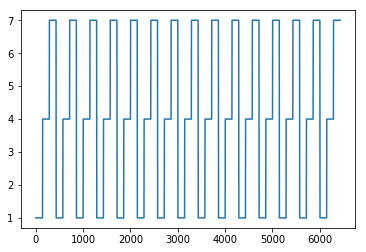

In [6]:
plt.plot(label)

In [0]:
label.shape

(6435,)

### Подготовка данных для обучения

In [0]:
# Разбиение на тестовую и обучающую выборки (random_state фиксирован для повторяемости результатов)
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=999)

# One-Hot Encoding
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train = enc.fit_transform(y_train.reshape(-1, 1))
y_test = enc.transform(y_test.reshape(-1, 1))

# Перекодируем категории в названия действий
categories = ['Working at Computer', 'Walking', 'Talking while Standing']
enc.categories_ = categories

In [8]:
print("Train dataset shape: ", X_train.shape)
print("Test dataset shape: ", X_test.shape)

Train dataset shape:  (5148, 104, 3)
Test dataset shape:  (1287, 104, 3)


## Обучение нейросети

In [0]:
# Полезные константы
lenght = X_train.shape[1]
num_features = X_train.shape[2]
num_classes = len(enc.categories_)
lstm_cells = 100
nb_epochs = 50
batch_size = 128

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 104, 3)       0                                            
__________________________________________________________________________________________________
batch_normalization_v1_106 (Bat (None, 104, 3)       12          input_29[0][0]                   
__________________________________________________________________________________________________
conv1d_79 (Conv1D)              (None, 52, 32)       800         batch_normalization_v1_106[0][0] 
__________________________________________________________________________________________________
batch_normalization_v1_107 (Bat (None, 52, 32)       128         conv1d_79[0][0]                  
__________________________________________________________________________________________________
activation

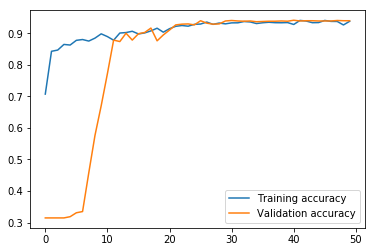

In [84]:
# Коллбэки
model_callbacks = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00005, verbose=1)
]

# Входные данные
inp = layers.Input((lenght, num_features))

# Ветка LSTM
lstm = layers.LSTM(lstm_cells)(inp)
lstm = layers.Dropout(0.8)(lstm)

# Ветка fcm
fcm = layers.BatchNormalization()(inp)
fcm = layers.Conv1D(32, 8, 2, padding='same')(fcm)
fcm = layers.BatchNormalization()(fcm)
# fcm = layers.Dropout(0.2)(fcm)
fcm = layers.Activation('relu')(fcm)
    
fcm = layers.Conv1D(64, 5, 2, padding='same')(fcm)
fcm = layers.BatchNormalization()(fcm)
fcm = layers.Dropout(0.1)(fcm)
fcm = layers.Activation('relu')(fcm)
    
fcm = layers.Conv1D(32, 3, 2, padding='same')(fcm)
fcm = layers.BatchNormalization()(fcm)
# fcm = layers.Dropout(0.1)(fcm)
fcm = layers.Activation('relu')(fcm)
    
fcm = layers.GlobalAveragePooling1D()(fcm)

total = layers.Concatenate()([lstm, fcm])

out = layers.Dense(num_classes, activation='softmax')(total)

model = Model(inputs=inp, outputs=out)
     
optimizer = optimizers.Adam(lr=0.005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

model.summary()

# Обучаем. Данные шумные, так что метрика на валидации не сразу начнет улучшаться
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs, verbose=1, validation_data=(X_test, y_test), callbacks=model_callbacks)

### График обучения

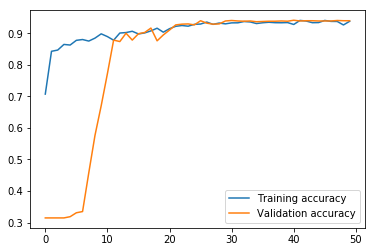

In [97]:
# График
plt.plot(hist.history["acc"], label='Training accuracy')
plt.plot(hist.history["val_acc"], label='Validation accuracy')
plt.legend()
plt.show()

# Визуальная проверка предсказания

In [0]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1)

expected = np.argmax(y_test, axis=1)

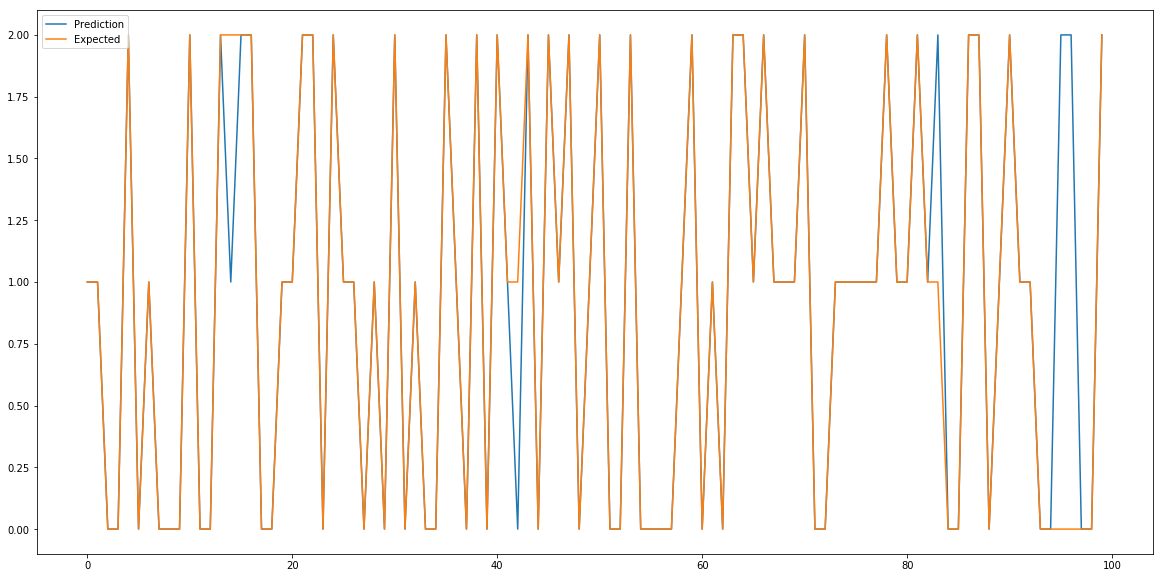

In [96]:
plt.figure(figsize=(20,10)) 
plt.plot(prediction[:100], label="Prediction")
plt.plot(expected[:100], label="Expected")
plt.legend()
plt.show()